In [1]:
import pyvista as pv
# import topogenesis  as tp
import numpy as np
from honeybee_plus.hbsurface import HBSurface
from honeybee_plus.radiance.recipe.solaraccess.gridbased import SolarAccessGridBased
from honeybee_plus.radiance.sky.certainIlluminance import CertainIlluminanceLevel
from honeybee_plus.radiance.recipe.pointintime.gridbased import GridBased
from honeybee_plus.radiance.analysisgrid import AnalysisGrid
import os
import ladybug as lb
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

cwd = os.getcwd()
src = os.path.dirname(cwd)

Path to radiance is set to: /usr/local/radiance
Path to perl is set to: /usr/bin


In [2]:
nproc_cmd = 'sysctl -n hw.ncpu'
proc = subprocess.Popen(nproc_cmd, shell=True, stdout=subprocess.PIPE)
nproc = int(proc.communicate()[0])
nproc

8

In [3]:
material_glass = {'modifier': 'void', 
                 'type': 'glass', 
                 'name': 'generic_glass', 
                 'r_transmittance': 0.88, 
                 'g_transmittance': 0.88, 
                 'b_transmittance': 0.88, 
                 'refraction_index': 1.52
                }
material_plastic = {'modifier': 'void', 
                   'type': 'plastic', 
                   'name': 'generic_plastic', 
                   'r_reflectance': 0.5, 
                   'g_reflectance': 0.5, 
                   'b_reflectance': 0.5, 
                   'specularity': 0.0, 
                   'roughness': 0.0}
def mesh_to_hbsurface(mesh, s_type, s_name, mat):
    hb_surfaces = []
    face_list = list(mesh.faces)
    e = 0
    while e < len(face_list):
        v_count = face_list[e]
        vertices = []
        for v in range(v_count):
            e += 1
            vertices.append(list(mesh.points[face_list[e]]))
        srf_dict = {
            "name": s_name,
            "vertices": vertices, # [[(x, y, z), (x1, y1, z1), (x2, y2, z2)]],
            "surface_material": mat,
            "surface_type": s_type  # 0: wall, 5: window 
            # TODO: look for the lables of ceiling and floor
            }
        srf_dict["surface_material"]["name"] = s_name
        hbsrf = HBSurface.from_json(srf_dict)
        hb_surfaces.append(hbsrf)
        e += 1
    return hb_surfaces

In [4]:
# import all external geometry with pyvista
wal_filepath = os.path.join(src, "data", "test_room_walls_02.obj")
wal_mesh = pv.read(wal_filepath)
fen_filepath = os.path.join(src, "data", "test_room_fens_02.obj")
fen_mesh = pv.read(fen_filepath)

con_buildings_filepath = os.path.join(src, "data", "test_context_01_buildings.obj")
con_buildings_mesh = pv.read(con_buildings_filepath)
con_ground_filepath = os.path.join(src, "data", "test_context_01_ground.obj")
con_ground_mesh = pv.read(con_ground_filepath)
# con_sky_filepath = os.path.join(src, "data", "test_context_01_sky.obj")
# con_sky_mesh = pv.read(con_sky_filepath)
con_vegetation_filepath = os.path.join(src, "data", "test_context_01_vegetation.obj")
con_vegetation_mesh = pv.read(con_vegetation_filepath)

# construct honeybee surfaces from the mesh
wal_hb_surf = mesh_to_hbsurface(wal_mesh, 0, "wall", material_plastic)
fen_hb_surf = mesh_to_hbsurface(fen_mesh, 5, "window", material_glass)
con_buildings_hb_surf = mesh_to_hbsurface(con_buildings_mesh, 0, "context_buildings", material_plastic)
con_ground_hb_surf = mesh_to_hbsurface(con_ground_mesh, 0, "context_ground", material_plastic)
# con_sky_hb_surf = mesh_to_hbsurface(con_sky_mesh, 0, "context_sky", material_plastic)
con_vegetation_hb_surf = mesh_to_hbsurface(con_vegetation_mesh, 0, "context_vegetation", material_plastic)

hb_surfaces = wal_hb_surf + fen_hb_surf + con_buildings_hb_surf + con_ground_hb_surf + con_vegetation_hb_surf
# TODO: look into tagging system for out_view to specify the "external environment"

# print(hb_surfaces)
# print(type(mesh))
# print(mesh.points)
# print(mesh.faces)

In [5]:
# generate grid of test points
test_pts = [(1, 1, 1),(6, 1, 1),(1, 6, 1),(1, 1, 6)]
test_vec = [(0, 0, 1),(0, 0, 1),(0, 0, 1),(0, 0, 1)]
analysis_grid = AnalysisGrid.from_points_and_vectors(test_pts, test_vec, 'test_grid')

# generate the sky
sky = CertainIlluminanceLevel(illuminance_value=10000,sky_type=1)
print(CertainIlluminanceLevel.__doc__)

# put the recipe together
rp = GridBased(sky=sky, analysis_grids=(analysis_grid,), simulation_type=0,
               hb_objects=hb_surfaces)

Uniform CIE sky based on illuminance value.

    Attributes:
        illuminance_value: Desired illuminance value in lux
        sky_type: An integer between 0..1 to indicate CIE Sky Type.
            [0] cloudy sky, [1] uniform sky (default: 0)
        suffix: An optional suffix for sky name. The suffix will be added at the
            end of the standard name. Use this input to customize the new and
            avoid sky being overwritten by other skymatrix components.
    Usage:

        sky = CertainIlluminanceLevel(1000)
        sky.execute("c:/ladybug/1000luxsky.sky")
    
Found 5486 opaque surfaces.
Found 1 fenestration surfaces.
Found 0 window-groups.


In [6]:
# write simulation to folder
batch_file = rp.write(
    target_folder='.', project_name='external_context_view')

# print the radiance commands
for i,com in enumerate(rp._commands):
    print(i, com)

# change the commands
#rp._commands[3] = "/usr/local/radiance/bin/rtrace -os -aa 0.25 -ab 0 -ad 512 -ar 16 -as 128 -dc 0.25 -dj 0.0 -dp 64 -ds 0.5 -dr 0 -dt 0.5 -e error.txt -h -I -lr 4 -lw 0.05 -ss 0.0 -st 0.85 external_context_view.oct < external_context_view.pts > result/external_context_view.res"



Writing recipe contents to: ./external_context_view/gridbased
0 #!/usr/bin/env bash



cd ./external_context_view/gridbased

1 /usr/local/radiance/bin/gensky 9 21 12 -u -B 55.865921787709496 > sky/CertainIlluminanceLevel_10000.sky
2 /usr/local/radiance/bin/oconv -f sky/CertainIlluminanceLevel_10000.sky sky/groundSky.rad scene/opaque/external_context_view..opq.mat scene/opaque/external_context_view..opq.rad scene/glazing/external_context_view..glz.mat scene/glazing/external_context_view..glz.rad > external_context_view.oct
3 /usr/local/radiance/bin/rtrace -aa 0.25 -ab 2 -ad 512 -ar 16 -as 128 -dc 0.25 -dj 0.0 -dp 64 -ds 0.5 -dr 0 -dt 0.5 -e error.txt -h -I -lr 4 -lw 0.05 -ss 0.0 -st 0.85 external_context_view.oct < external_context_view.pts > result/external_context_view.res
4 /usr/local/radiance/bin/rcalc -e '$1=(0.265*$1+0.67*$2+0.065*$3)*179' result/external_context_view.res > result/external_context_view.ill


In [7]:
# run the simulation
rp.run(batch_file, debug=False)

# https://www.radiance-online.org/learning/documentation/manual-pages/pdfs/rmtxop.pdf
# Eleonora: rmtxop multiplies the daylight coefficient matrices with the sky vectors. This is necessary for getting illuminance from daylight coefficients computed w.r.t. rgb components. 
# Sun Access of points, and how to interpret them https://floyd.lbl.gov/radiance/refer/usman2.pdf

True

In [8]:
# results - in this case it will be an analysis grid
result = rp.results()[0]
dfs = []

# print(result.result_files)
for i, ap in enumerate(result._analysis_points):
    data_dict = ap._values[0][0]
    print(data_dict)
    # df = pd.DataFrame(data_dict)
    # dft = df.T
    # dft.columns = [i, i+1]
    # dfs.append(dft[i])

# df = pd.concat(dfs, axis=1)
# print(df)
# print(sum(df[0])/4460.0)
# print(sum(df[1])/4460.0)
# print(sum(df[2])/4460.0)
# print(sum(df[3])/4460.0)
# df = pd.DataFrame({
#   'IX': vol_3d_ind_flat[:, 0],
#   'IY': vol_3d_ind_flat[:, 1],
#   'IZ': vol_3d_ind_flat[:, 2],
#   'value': vol_flat,
#})
# print result with legend
# leg = ["Daylight autonomy", "Continious daylight autonomy", "Useful daylight illuminance", "Less than UDI", "More than UDI"]
# for l, d in zip(leg, result.annual_metrics(da_threshhold=1)):
#    print(l, d)

# extract the points of interest from the recipe
result_points = [[p[0], p[1], p[2]] for p in result.points]

Unloading the current values from the analysis grids.
defaultdict(<function AnalysisPoint._create_data_structure.<locals>.double at 0x7f9b81e4ec10>, {379440: [1098, None]})
defaultdict(<function AnalysisPoint._create_data_structure.<locals>.double at 0x7f9b81e4edc0>, {379440: [4255, None]})
defaultdict(<function AnalysisPoint._create_data_structure.<locals>.double at 0x7f9b81e4e8b0>, {379440: [3447, None]})
defaultdict(<function AnalysisPoint._create_data_structure.<locals>.double at 0x7f9b81e4e040>, {379440: [8309, None]})


In [9]:
# Plot using the ITKplotter
pl = pv.PlotterITK()
# add the external wall mesh
pl.add_mesh(wal_mesh, smooth_shading=True)
# add the external fens mesh, transparrent blue
pl.add_mesh(fen_mesh, smooth_shading=True, opacity=0.3, color='#c1e2ff')
# add the context mesh, transparrent grey
pl.add_mesh(con_buildings_mesh, smooth_shading=True, opacity=0.3)
pl.add_mesh(con_ground_mesh, smooth_shading=True, opacity=0.3)
# pl.add_mesh(con_sky_mesh, smooth_shading=True, opacity=0.3)
pl.add_mesh(con_vegetation_mesh, smooth_shading=True, opacity=0.3)
# add points of interest : blue
pl.add_points(pv.PolyData(result_points), color='#2499ff')
# add sun points : orange
# pl.add_points(pv.PolyData(np.array(sun_vectors) * -120), color='#ffa500')
# show the plot
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
import honeybee_plus

project_name='external_context_view'
octf = src+'/recipe_notebooks/external_context_view/gridbased/external_context_view.oct'

view = honeybee_plus.radiance.view.View(name='indoor_fisheye', 
                                 view_point=(1,1,1),
                                view_direction=(0,-1,0),
                                view_up_vector=(0,0,1),
                                view_type=4,
                                view_h_size=180,
                                view_v_size=180,
                                x_resolution=128,
                                y_resolution=128)

rp_rpict = honeybee_plus.radiance.parameters.rpict.RpictParameters(0)
rp_rtrace = honeybee_plus.radiance.parameters.rtrace.LowQuality()
rp_rtrace.remove_parameters() # I didn't find a more elegant way to initialise the parameter class
rp_rtrace.add_radiance_number('ab')
rp_rtrace.ab = 0
rp_rtrace.add_radiance_value('o', is_joined=True)
rp_rtrace.o = 'vmlL'
rp_rtrace.add_radiance_bool_flag('w')
rp_rtrace.w = True

print(rp_rpict.to_rad_string())
print(rp_rtrace.to_rad_string())

# honeybee_plus.radiance.recipe.pointintime.imagebased
# doesn't work -- I get: AttributeError: module 'honeybee_plus.radiance.recipe.pointintime' has no attribute 'imagebased'

Changed view_h_size and view_v_size to 180 for fisheye view type.
-aa 0.25 -ab 2 -ad 512 -ar 16 -as 128 -dc 0.25 -dj 0.0 -dp 64 -ds 0.5 -dr 0 -dt 0.5 -lr 4 -lw 0.05 -pj 0.6 -ps 8 -pt 0.15 -ss 0.0 -st 0.85
-ab 0 -ovmlL -w


In [11]:
rpict_cmd_0 = 'rpict -w %s %s -af %s/%s.af %s > /dev/null' % (rp_rpict, view, project_name, project_name, octf)
rpict_cmd = 'rpict -w %s %s -af %s/%s.af %s > %s/%s.hdr' % (rp_rpict, view, project_name, project_name, octf, project_name, project_name)
normtiff_cmd = 'normtiff -h %s/%s.hdr %s/%s.tif' % (project_name, project_name, project_name, project_name)

rpict = subprocess.Popen(rpict_cmd_0, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
rpict = subprocess.Popen(rpict_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
rpict.communicate()
normtiff = subprocess.Popen(normtiff_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
normtiff.communicate()

(b'', b'')

In [12]:
rtrace_cmd = 'vwrays %s | rtrace %s %s > %s/rtrace_res.txt' % (view, rp_rtrace, octf, project_name)

rtrace = subprocess.Popen(rtrace_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
rtrace.communicate()

(b'', b'')

In [13]:
rtrace_res = pd.read_csv('%s/rtrace_res.txt' % project_name, skiprows=8, sep='\t', header=None)
rtrace_res

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,wall,3.508846,3.508846,NaN
1,0.0,0.0,0.0,wall,3.438210,3.438210,NaN
2,0.0,0.0,0.0,wall,3.370834,3.370834,NaN
3,0.0,0.0,0.0,wall,3.306528,3.306528,NaN
4,0.0,0.0,0.0,wall,3.245116,3.245116,NaN
...,...,...,...,...,...,...,...
16379,0.0,0.0,0.0,context_ground,1.622558,1.622558,NaN
16380,0.0,0.0,0.0,context_ground,1.653264,1.653264,NaN
16381,0.0,0.0,0.0,context_ground,1.685417,1.685417,NaN
16382,0.0,0.0,0.0,context_ground,1.719105,1.719105,NaN


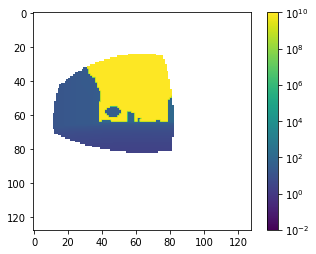

2.2799560000000003 10000000000.0


In [19]:
# distances outside the window

labels_array = rtrace_res[3]
window_dist_array = rtrace_res[4].values.reshape(int(view.x_resolution), int(view.y_resolution))
window_dist_masked = np.ma.masked_where((labels_array!='window'), rtrace_res[4]).reshape(int(view.x_resolution), int(view.y_resolution))

plt.imshow(window_dist_masked, origin='upper', norm=LogNorm(vmin=0.01, vmax=1e10))
plt.colorbar()
plt.show()

print(window_dist_masked.min(), window_dist_masked.max())

In [20]:
# Distances and angles on the central row (eye level)

cx, cy = int(int(view.x_resolution)/2), int(int(view.y_resolution)/2)

c_row = labels_array.iloc[int(view.x_resolution)*(cy-1):int(view.x_resolution)*(cy)]
window_h_aperture_angle = c_row.groupby(c_row).count()['window'] * 180 / int(view.x_resolution)
window_h_aperture_angle

101.25

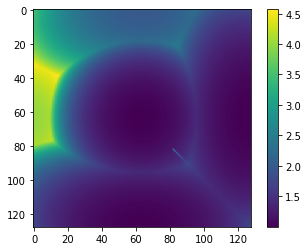

1.000106 4.568531 1.000151


In [21]:
# distances within the room

dist_array = rtrace_res[5].values.reshape(int(view.x_resolution),int(view.y_resolution))
dist_c = dist_array[cx, cy]

plt.imshow(dist_array, origin='upper')
plt.colorbar()
plt.show()

print(dist_array.min(), dist_array.max(), dist_c)